# Geometry-Inspired Control of the Brockett-Integrator in Cylinder Coordinates

This Notebook documents the important calculations for the conference contribution entitled "Geometry-Inspired Control of the Brockett-Integrator in Cylinder Coordinates" presented at the GAMM annual meeting 2018.

**Note** This Jupyter-Notebook is currently mostly in German and will be translated in the near future.



Dieses Notebook untersucht den Brockett-Integrator


\begin{align}
%\label{eq_}
\dot x_1 &= u_1\\
\dot x_2 &= u_2\\
\dot x_3 &= x_2 u_1 - x_1 u_2
\end{align}




In [1]:
import time
time.ctime()

'Mon Mar 19 20:43:40 2018'

### Technische Abhängigkeiten:


https://github.com/TUD-RST/symbtools

https://github.com/cknoll/ipydex (for displaytools)
'

In [2]:
%load_ext ipydex.displaytools

import sympy as sp
import numpy as np
import scipy as sc
import scipy.integrate
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline

import symbtools as st
from sympy.interactive import printing
printing.init_printing(1)


plt.rc('text.latex', preamble=r'\usepackage{amsmath}') # für \text{..}
plt.rcParams['text.usetex'] = True

plt.rcParams['figure.subplot.bottom'] = .265
plt.rcParams['figure.subplot.left'] = .21
plt.rcParams['figure.subplot.top'] = .98
plt.rcParams['figure.subplot.right'] = .98

plt.rcParams['figure.subplot.hspace'] = .5 # vertikaler Abstand
plt.rcParams['figure.subplot.wspace'] = .5 # horizontaler Abstand

plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14


In [3]:
xx = st.symb_vector("x1:4")
uu = st.symb_vector("u1:3")
zz = st.symb_vector("z1:4")
vv = st.symb_vector("v1:3")
st.make_global(xx, uu, zz, vv)

### Lässt sich das System in die *regular Form* (Khalil S. 564) überführen?
→ Involutivitätsuntersuchung

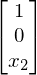

---


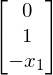

---


In [4]:
b1 = sp.Matrix([1, 0, x2]) ##:
b2 = sp.Matrix([0, 1, -x1]) ##:
B = st.col_stack(b1, b2)

Involutivitäts-Test

In [5]:
st.involutivity_test(B, xx)

(False, (0, 1))

→ nicht involutiv.


Das sieht man auch direkt

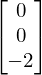

---


In [6]:
ad_b1_b2 = st.lie_bracket(b1, b2, xx) ##

Damit ist die Lie-Algebra-Rang-Bedingung offensichtilich auch erfüllt:

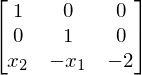

---


In [7]:
test_matrix = st.col_stack(b1, b2, ad_b1_b2) ##:
st.generic_rank(test_matrix)

### Herleitung eines schaltenden Regelgesetzes, welches den Ursprung (vermutlich)  global asymtoptisch stabilisiert
 * basiert auf Darstellung in Zylinderkoordinaten

Wdh.: Darstellung in Originalkoordinaten:

$
\begin{align}
%\label{eq_}
\dot x_1 &= u_1\\
\dot x_2 &= u_2\\
\dot x_3 &= x_2 u_1 - x_1 u_2
\end{align}
$

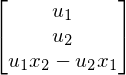

---


In [8]:
ff = B*uu ##:

### Herleitung: Systemdynamik in Zylinderkoordinaten:


\begin{align}
%\label{eq_}
r &= z_1 =  \sqrt{x_1^2 + x_2^2} \\
\varphi &= z_2 = \mathrm{arctan2}(x_2, x_1) \\
z &= z_3 = x_3
\end{align}


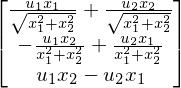

---


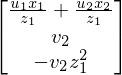

---


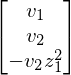

---


In [9]:
z1e = sp.sqrt(x1**2 + x2**2)
z2e = sp.atan2(x2, x1)
z3e = x3

zz_expr = sp.Matrix([z1e, z2e, z3e])

rplm1 = [(z1e, z1), (sp.expand(-ff[2]/z1**2), v2), (ff[2], -z1**2*v2)]

ffz = zz_expr.jacobian(xx)*ff ##:
ffz = ffz.subs(rplm1) ##:
rplm2 = [(ffz[0], v1)]
ffz = ffz.subs(rplm2) ##:


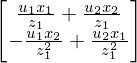

---


In [10]:
vve = vv.subs(st.rev_tuple(rplm1+rplm2)) ##:


In [11]:
from symbtools import interactive_aux as ia

In [12]:
ia.adapted_latex(vve)

\left(\begin{matrix}
\frac{u_{1} x_{1}}{z_{1}} + \frac{u_{2} x_{2}}{z_{1}}\\
- \frac{u_{1} x_{2}}{z_{1}^{2}} + \frac{u_{2} x_{1}}{z_{1}^{2}}
\end{matrix}\right)
% -------------


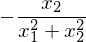

In [13]:
z2e.diff(x1)

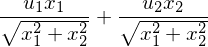

___


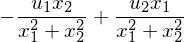

___


In [14]:
st.lie_deriv(z1e, ff, xx) ##:
st.lie_deriv(z2e, ff, xx) ##:

Rücktranstformation des Eingangs

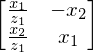

___


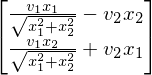

---


In [15]:
M = vve.jacobian(uu).inverse_ADJ()
M.simplify()
M.subs(rplm1) ##:

# uue = M.subs(rplm1) * vv ##:

uue = M.subs(st.rev_tuple(rplm1[:1])) * vv ##:

In [16]:
ia.adapted_latex(uue)

\left(\begin{matrix}
\frac{v_{1} x_{1}}{\sqrt{x_{1}^{2} + x_{2}^{2}}} - v_{2} x_{2}\\
\frac{v_{1} x_{2}}{\sqrt{x_{1}^{2} + x_{2}^{2}}} + v_{2} x_{1}
\end{matrix}\right)
% -------------


In [17]:
# probe
vve.subz(uu, uue).smplf.subs(st.rev_tuple(rplm1[:1]))

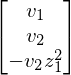

In [18]:
ffz

### Konstrunktion einer möglichst kurzen Kurve von der z3-Achse in den Ursprung

Drei Phasen:
1. $z_1$ vergrößern → $r_1$
2. mit $v_2=$const nach unten/oben "schrauben" ($z_2$ und $z_3$ verändern, bis $z_3=0$)
3. $z_1$ verkleinern


\begin{align}
%\label{eq_}
L &= r_1 + \int_0^T \sqrt{\dot x_1^2 +  \dot x_2^2 + \dot x_3^2 }\, dt + r_1\\
&= r_1 + \int_0^T \sqrt{(r_1 \dot z_2)^2 + \dot z_3^2 }\, dt + r_1\\
&= 2 r_1 + \int_0^T \sqrt{  (r_1 v_2)^2 + r_1^4 v_2^2}\, dt \\
&= 2 r_1 + (r_1 v_2)\sqrt{( 1+ r_1^2)} \int_0^T \, dt \\
&= 2 r_1 + (r_1 v_2)\sqrt{( 1+ r_1^2)}T \\
\end{align}


$
\Delta z_3 = - T r_1^2 v_2 \quad \Rightarrow \quad T = - \frac{\Delta  z_3 }{r_1^2 v_2}
$

<br>

$
\Rightarrow L= 2 r_1 - (r_1 v_2)\sqrt{( 1+ r_1^2)} \cdot \frac{\Delta  z_3 }{r_1^2 v_2}
$

In [19]:

r1, dz3 = sp.symbols('r1, \Delta{}z_3', positive=True) ##

---


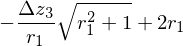

---


In [20]:
Le = sp.expand(2*r1-(r1*v2)*sp.sqrt(1+r1**2)*dz3/r1**2/v2) ##:

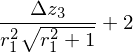

---
\frac{\Delta{}z_3}{r_{1}^{2} \sqrt{r_{1}^{2} + 1}} + 2
% -------------


In [21]:
Led = Le.diff(r1).smplf ##:

ia.adapted_latex(Led)

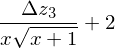

---


In [22]:
# manual solution (biquadratic equation)
x = sp.Symbol("x")
Ledx = Led.subs(r1**2, x) ##:

In [23]:
sol1, sol2, sol3 = sp.solve(Ledx, x)

In [27]:
# generate some latex for the slides
# ia.adapted_latex(sol2)

In [28]:
dz3

In [29]:
sol = sp.solve(Le.diff(r1), r1)

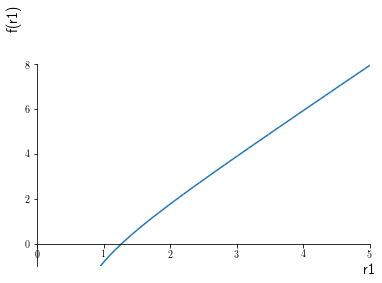

In [30]:
sp.plot(Le.subs(dz3, 2), (r1, 0, 5), ylim=(-1, 10))

In [31]:
for i, s in enumerate(sol):
    print(i, s.subs(dz3, 1).evalf())

0 -0.176100564369479 - 0.860716618623568*I
1 0.176100564369479 + 0.860716618623568*I
2 -0.647798871261042 - 4.67618288267623e-27*I
3 0.647798871261042 + 0.e-25*I
4 -0.176100564369479 + 0.860716618623568*I
5 0.176100564369479 - 0.860716618623568*I


In [32]:
def r1_opt(dz3_value):
    results = [s.subs(dz3, dz3_value).evalf() for s in sol]
    
    results.sort(key=lambda x: abs(sp.im(x)))
    
    r1 = sp.re(results[0])
    if r1 < 0:
        r1 = sp.re(results[1])
    assert r1 >= 0
    return r1

# Probe
for p in [0.01, .1, 1, 10]:
    print(r1_opt(p))
    

0.0706227831905930
0.220957890360505
0.647798871261042
1.62044085898296


In [33]:
# Speedup the evaluation later (prepare values for interpolation)
zz3 = np.logspace(-3, 3, 100)

rr_opt = [r1_opt(z3_value) for z3_value in zz3]


In [34]:
r1_opt_interp = sc.interpolate.interp1d(zz3, rr_opt, bounds_error=False, fill_value="extrapolate")

#### optimaler Wert von $r_1$ in Abhängigkeit von $\Delta z_3$

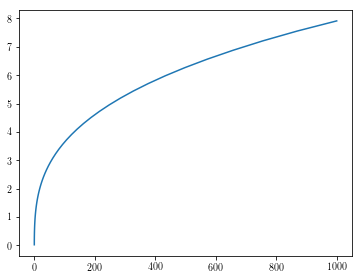

In [35]:
plt.plot(zz3, r1_opt_interp(zz3))

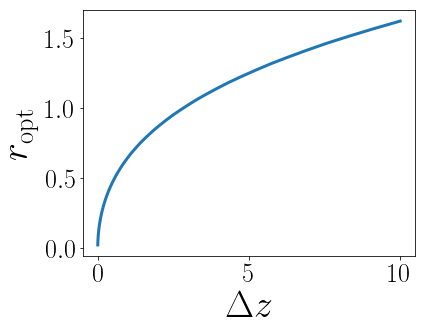

In [36]:
# produce figrue for the slides

plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 38

zz3 = np.logspace(-3, 1, 100)
plt.plot(zz3, r1_opt_interp(zz3), lw=3)
plt.xlabel(r"$\Delta z$")
plt.ylabel(r"$r_\mathrm{opt}$")
plt.savefig("r_opt__Delta_z.pdf")

In [37]:
# Stichproben-Vergleich:

r1_opt_interp(.7) ##:
r1_opt(.7)##:

r1_opt_interp(.7)  := array(0.5533069892183082)

___


___


### Simulation Experiments

#### Vector Field

In [42]:
def rhs(state, _):
    u1, u2 = controller(state)
    x1, x2, x3 = state
    return np.array([u1, u2, x2*u1 - x1*u2])

vv_to_uu = sp.lambdify((v1, v2, x1, x2), list(uue))
z3_tol = 1e-2


#### Control Law

In [43]:
def controller(state):
    x1, x2, x3 = state
    z1 = np.sqrt(x1**2 + x2**2)
    z3 = x3
    
    r1_opt_value = r1_opt_interp(abs(z3))
    
    if z1 == 0:
        # go in x1 direction if phi is not well definded (at r=0)
        return [1, 0]
    
    if z1 < r1_opt_value and abs(z3) >= z3_tol:
        # Phase 1
        v1 = 1
        v2 = 0
    
    elif z1 >= r1_opt_value and abs(z3) >= z3_tol:
        # Phase 2
        v1 = 0
        v2 = np.sign(z3)
    elif abs(z3) < z3_tol:
        # Phase 3
        v1 = -1
        v2 = 0
    else:
        raise ValueError("Unexpected state: %s" % state)
        
    # calculate u1, u2, from v1, v2
    return vv_to_uu(v1, v2, x1, x2)

#### Euler-Vorwärts-Verfahren für Integration

In [44]:
def euler(rhs, y0, T, dt=.01):
    res=[y0]
    tt=[0]
    while tt[-1] <= T:
        x_old = res[-1]
        res.append(x_old+dt*rhs(x_old, 0))
        tt.append(tt[-1] + dt)
    return tt, np.array(res)
    
    

In [45]:
tt = np.linspace(0, 5, int(1e2))
xx0 = np.array([1, 0, 5])


controller(xx0)
rhs(xx0, 0)

def simulate(xx0):
    tt, xxn = euler(rhs, xx0, 4, dt=.01)
    return np.array(xxn)



In [46]:
N = 5
np.random.seed(1)
xx0_values = (np.random.rand(N, 3) - .5)*1

res = [simulate(xx0) for xx0 in xx0_values]

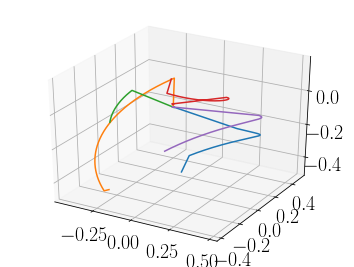

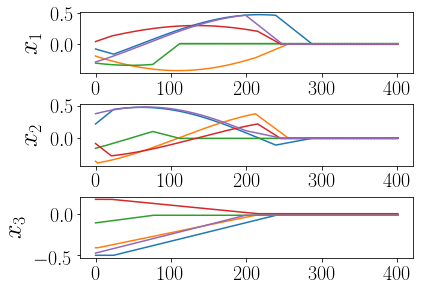

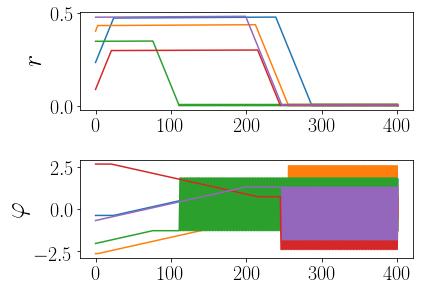

In [47]:
# Interaktives Plot-Fenster:
# %matplotlib qt5

# Alternativ: Grafiken Eingebunden
%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 26

fig_3d = plt.figure(1)
ax0 = fig_3d.gca(projection='3d')

fig_xx = plt.figure(2)
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

fig_rphi = plt.figure(3)

ax4 = plt.subplot(211)
ax5 = plt.subplot(212)

for xxn in res:
    z1 = np.sqrt(xxn[:, 0]**2 + xxn[:, 1]**2)
    z2 = np.arctan2(xxn[:, 0], xxn[:, 1])
    z3 = xxn[:, 2]
    
    ax0.plot(xxn[:, 0], xxn[:, 1], xxn[:, 2])
    ax1.plot(xxn[:, 0])
    ax2.plot(xxn[:, 1])
    ax3.plot(xxn[:, 2])
    
    ax4.plot(z1)
    ax5.plot(z2)

ax1.set_ylabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax3.set_ylabel("$x_3$")

ax4.set_ylabel("$r$")
ax5.set_ylabel(r"$\varphi$")

fig_3d.savefig("bi-3d-01.pdf")
fig_xx.savefig("bi-xx-01.pdf")
fig_rphi.savefig("bi-rphi-01.pdf")
plt.show()
